# Variational Inference

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as D
from torch.autograd.functional import hessian
from tqdm.notebook import tqdm
import jax
import jax.numpy as jnp
from jax import jit
from jax.scipy.stats import norm


## Problem Statement

Given a (potentially unnormalized) density function $p(z)$ that is easy to evaluate at any point $z$ (up to a normalization constant), the objective is to sample from $p(z)$.

This issue often arises in Bayesian inference. When provided with data $D$ and a model $p(D, z)$, where $z$ are latent variables, the posterior distribution over the latent variables is:

$$
p(z \mid D) \propto p(D \mid z) \, p(z)
$$

This posterior function can readily be evaluated for any given set of latent variables $z$, up to a normalization constant. However, generating samples according to this distribution can be a challenging task.

Possible solutions:

MCMC

Variational Inference

## Variational Inference

One way to solve this problem is to find a distribution $q(z)$ that is "similar" to the target distribution $p(z)$, but from which it is easy to sample (for example, a Gaussian distribution). This approximating distribution $q(z)$ is often called the **guide**.

The space of distributions that are easy to sample from is vast. How do we choose among all these possibilities? To simplify, we can restrict ourselves to a parametric family of distributions $q_\lambda(z)$ that depends on a set of parameters $\lambda$. For example, the family of Gaussian distributions $ \mathcal{N}(\mu, \sigma^2)$ is parameterized by $\lambda = (\mu, \sigma^2)$. Searching for the best guide then becomes an optimization problem to find the optimal parameters $\lambda$.

But how do we measure the similarity between two distributions?

### Kullback-Leibler Divergence

The *Kullback–Leibler (KL) divergence* (or relative entropy) measures how one probability distribution diverges from a second, reference probability distribution. It's a fundamental divergence measure in information theory, statistics, and machine learning.

For discrete probability distributions $P$ and $Q$:

$$
D_{\text{KL}}(P \parallel Q) = \sum_{i=1}^{n} P(x_i) \log_2 \frac{P(x_i)}{Q(x_i)}
$$
The relative entropy satisﬁes Gibbs’ inequality

$$
D_{\text{KL}}(P \parallel Q) \geq 0
$$

#### Intuition Behind KL Divergence

- **Information Content**: Information content (or surprise) of an event in a probabilistic sense is given by the negative logarithm of its probability. For an event with probability $p$, the information content is $-\log(p)$. Rare events (with low probability) have high information content, since they provide more 'surprise' when they occur, while common events (with high probability) have low information content.
- **Comparing Two Distributions**: Suppose we have two probability distributions: $P$ (true distribution) and $Q$ (approximate or reference distribution). The KL divergence $D_{KL}(P \parallel Q)$ measures the inefficiency or extra information content when $Q$ is used instead of $P$.
- **Expected Extra Information**: KL divergence computes the expected difference in information content when using $Q$ instead of $P$. Specifically, it looks at how much more surprise would occur if you expect events according to $Q$ but reality follows $P$.
- **If $P$ and $Q$ are the same:** The divergence is zero, meaning no extra information is needed—there's no inefficiency.
- **If $P$ and $Q$ differ:** The divergence is positive, indicating an inefficiency due to using $Q$ instead of $P$.
- **Non-negative**: $D_{\text{KL}}(P \parallel Q) \geq 0$, with equality if $P = Q$.
- **Asymmetry**: It's not symmetrical; $D_{\text{KL}}(P \parallel Q) \neq D_{\text{KL}}(Q \parallel P)$.

From [@zhangDiveDeepLearning2024, p. 1061]:
an interpretation of the logarithmic term: $$−\log\frac{q(x)}{p(x)}=−\log(q(x)) − (−\log(p(x)))$$ will be large and positive if we see $x$ far more often under $P$ than we would expect for $Q$, and large and negative if we see the outcome far less than expected. In this way, we can interpret it as our relative surprise at observing the outcome compared to how surprised we would be observing it from our reference distribution.

Here is a break down of the Kullback–Leibler Divergence formula:

1. **Ratio:** $\frac{P(x)}{Q(x)}$
   - This ratio indicates how much more likely an event $x$ is under $P$ compared to $Q$.
2. **Logarithm:** $\log \left( \frac{P(x)}{Q(x)} \right)$
   - The logarithm of the ratio indicates the relative difference in information content between $P$ and $Q$ for that event $x$.
3. **Weight by:** $P(x)$
   - The factor $P(x)$ ensures that we are considering the difference in information content over the events that are more probable under the true distribution $P$.
4. **Sum over All Events:**
   - The weighted cumulative sum (or integral in the case of continuous distributions) over all possible events gives the expected extra information content.

Continuous case of KL


forward vs backward KL

https://agustinus.kristia.de/blog/forward-reverse-kl/#references

see also ∏@murphyMachineLearningProbabilistic2012 chapter 21


#### Example
Let us consider a simple example, in which our target distribution is a standard univariate normal distribution $p(x) ∼ N(0, 1)$ and the approximating distribution is a univariate normal with a mean $\mu$ and variance $\sigma^2 : q(x) ∼ N(\mu, \sigma^2 )$. 

Note reverse p and q as typical for variational inference.

We can then compute $KL(q ||p)$ as follows:

$$
\begin{aligned}
KL(q || p) &= \int q(x) \frac{q(x)}{p(x)} \\
&= - \int q(x) \log p(x) + \int q(x) \log q(x)\\
&= - \int q(x) \Big[ -\frac{1}{2} \log 2\pi - \frac{1}{2} x^2   \Big]  \\
&\phantom{{}=1}  + \int q(x) \Big[ -\frac{1}{2} \log 2\pi\sigma^2 - \frac{1}{2\sigma^2} (x -\mu )^2   \Big]  \\
&= \Big[\frac{1}{2} \log 2\pi + \frac{1}{2} (\sigma^2 + \mu^2) \Big] + \Big[-\frac{1}{2} \log 2\pi\sigma^2 -\frac{1}{2}    \Big] \\
&= -\frac{1}{2} (1 + \log \sigma^2 - \mu^2 - \sigma^2)
\end{aligned}
$$

This derivation is a special case of the derivation found in Appendix B of @kingmaAutoEncodingVariationalBayes2013

If we fix $\sigma^2=2$ we can plot $KL(q || p)$ for $\mu \in [-3,3]$. Notice that the KL divergence is non-negative and obtain it's minimum when $\mu = 0$, that is the mean of the approximating distribution is equal to the mean of the target distribution $p(x) ∼ N(0, 1)$.



In [3]:
def KL(mu, sigma):
    return -0.5 * (1 + np.log(sigma**2) - mu**2 - sigma**2)

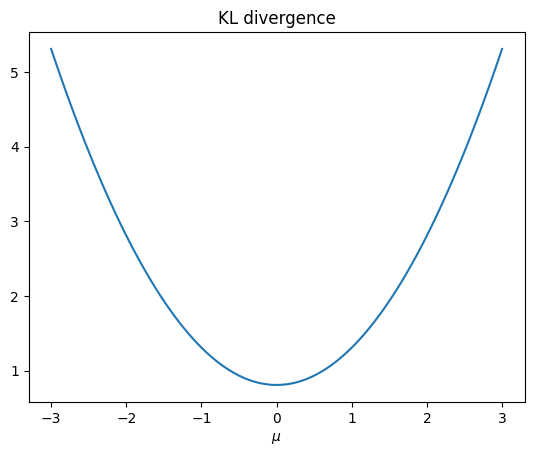

In [7]:
x = np.linspace(-3, 3, 100)
y = KL(x, 2)
plt.title("KL divergence")
plt.xlabel(r"$\mu$")
plt.plot(x, y);

## Laplace Approximation

simpel choice approx with gaussian. see @bishopPatternRecognitionMachine2006 for details.

let us see example of how to do this. example also illustrated that it is impossoble to captura multi modal target distributions.

examples is taken from lecture notes week2 slide 7.1


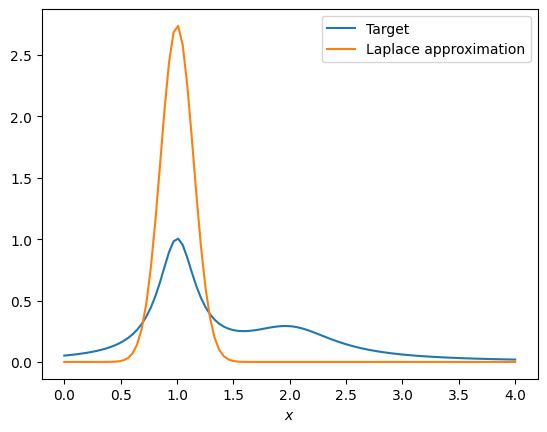

In [23]:
comp = D.StudentT(
    df=torch.tensor([1.0]), loc=torch.tensor([1.0, 2.0]), scale=torch.tensor([0.2, 0.5])
)

mix = mixture_distribution = D.Categorical(probs=torch.tensor([0.6, 0.4]))

mm = D.MixtureSameFamily(mix, comp)

x_mode = torch.tensor(1.0)
sigma = (-hessian(mm.log_prob, x_mode)) ** (-1 / 2)
laplace_approx = D.Normal(x_mode, sigma)

x = np.linspace(0, 4, 100)
y = torch.exp(mm.log_prob(torch.tensor(x)))
y1 = torch.exp(laplace_approx.log_prob(torch.tensor(x)))

plt.xlabel(r"$x$")
plt.plot(x, y, label="Target")
plt.plot(x, y1, label="Laplace approximation")
plt.legend();


## How to choose q(x)

see slide 21 week 2 lecture notes for two approaches





Mean field

CAVI

ELBO

Stochastic variational inference

reparametrizetion trick
https://github.com/DavideScassola/PML2024/blob/main/Notebooks/09_VI.ipynb
https://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/

Log-deriveate trick

see obsidian note for how to compute the derivate in case where the reparametrization trick does not apply

using pyro

inspiring note


https://www.cs.toronto.edu/~duvenaud/distill_bayes_net/public/
https://duvenaud.github.io/sta414/lectures/svi.pdf

https://duvenaud.github.io/sta414/ - look for Week 6 - Feb 14th & 15th - Variational Inference



https://www.ritchievink.com/blog/2019/09/16/variational-inference-from-scratch/


In [45]:
# From
# https://github.com/DavideScassola/PML2024/blob/main/Notebooks/09_VI.ipynb

import torch
import numpy as np
from torch.distributions import Normal
from tqdm import tqdm
from typing import Callable


def gradient_descent_optimization(
    *,
    loss_function: Callable[[torch.Tensor], torch.Tensor],
    lr: float,
    n_iter: int,
    initial_guess: np.ndarray,
) -> np.ndarray:
    """
    Perform gradient descent optimization.

    Args:
        loss_function (Callable[[torch.Tensor], torch.Tensor]): The loss function to minimize.
        lr (float): Learning rate.
        n_iter (int): Number of iterations.
        initial_guess (np.ndarray): Initial guess for the parameters.

    Returns:
        np.ndarray: Optimized parameters.
    """
    w = torch.tensor(initial_guess, dtype=torch.float32, requires_grad=True)
    for _ in tqdm(range(n_iter)):
        loss = loss_function(w)
        loss.backward()
        with torch.no_grad():
            w -= lr * w.grad
        w.grad = None
    print(f"loss={loss.item():.4g}")
    return w.cpu().detach().numpy()


def log_p(z: torch.Tensor) -> torch.Tensor:
    """
    Compute the log probability of z under the prior distribution.

    Args:
        z (torch.Tensor): Input tensor.

    Returns:
        torch.Tensor: Log probability.
    """
    return -3 * torch.abs(z - 2)


def log_q(z: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
    """
    Compute the log probability of z under the variational distribution.

    Args:
        z (torch.Tensor): Input tensor.
        mu (torch.Tensor): Mean of the variational distribution.
        sigma (torch.Tensor): Standard deviation of the variational distribution.

    Returns:
        torch.Tensor: Log probability.
    """
    return Normal(mu, sigma).log_prob(z)


def loss(param: torch.Tensor, num_samples: int = 10) -> torch.Tensor:
    """
    Compute the loss function for variational inference.

    Args:
        param (torch.Tensor): Parameters of the variational distribution.
        num_samples (int): Number of samples to draw.

    Returns:
        torch.Tensor: Loss value.
    """
    eps = torch.randn(num_samples)
    z = param[0] + param[1] * eps
    elbo_sample = log_p(z) - log_q(z, param[0], param[1])
    return -elbo_sample.mean(0)


params = gradient_descent_optimization(
    loss_function=loss, lr=0.01, n_iter=1000, initial_guess=np.array([0.0, 10.0])
)

mu, sigma = params[0], params[1]

100%|██████████| 1000/1000 [00:00<00:00, 7285.96it/s]

loss=0.4435


mean = 2.058, std = 0.405


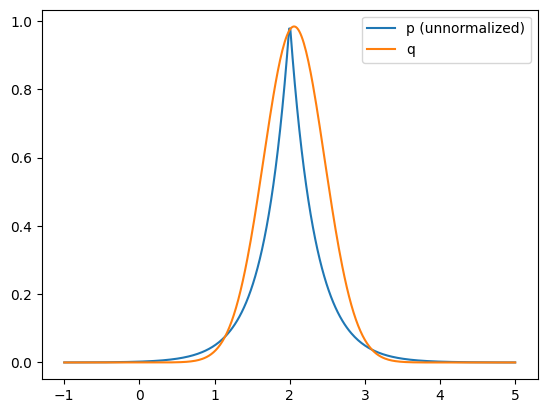

In [46]:
print(f"mean = {mu:.3f}, std = {sigma:.3f}")

# plotting the result
z_values = torch.linspace(-1, 5, 400)
log_p_values = log_p(z_values).exp()
log_q_values = log_q(z_values, mu, sigma).exp()
plt.figure(dpi=100)
plt.plot(z_values.numpy(), log_p_values.numpy(), label="p (unnormalized)")
plt.plot(z_values.numpy(), log_q_values.numpy(), label="q")
_ = plt.legend()

In [43]:
def gradient_descent_optimization(
    loss_function, lr: float, n_iter: int, initial_guess: np.ndarray
) -> np.ndarray:
    """
    Perform gradient descent optimization.

    Args:
        loss_function (Callable[[jnp.ndarray], jnp.ndarray]): The loss function to minimize.
        lr (float): Learning rate.
        n_iter (int): Number of iterations.
        initial_guess (np.ndarray): Initial guess for the parameters.

    Returns:
        np.ndarray: Optimized parameters.
    """
    w = jnp.array(initial_guess)
    for _ in tqdm(range(n_iter)):
        loss, grad_loss = jax.value_and_grad(loss_function)(w)
        w -= lr * grad_loss
    print(f"loss={loss:.4g}")
    return np.array(w)


@jit
def log_p(z: jnp.ndarray) -> jnp.ndarray:
    """
    Compute the log probability of z under the prior distribution.

    Args:
        z (jnp.ndarray): Input tensor.

    Returns:
        jnp.ndarray: Log probability.
    """
    return -3 * jnp.abs(z - 2)


@jit
def log_q(z: jnp.ndarray, mu: jnp.ndarray, sigma: jnp.ndarray) -> jnp.ndarray:
    """
    Compute the log probability of z under the variational distribution.

    Args:
        z (jnp.ndarray): Input tensor.
        mu (jnp.ndarray): Mean of the variational distribution.
        sigma (jnp.ndarray): Standard deviation of the variational distribution.

    Returns:
        jnp.ndarray: Log probability.
    """
    return norm.logpdf(z, mu, sigma)


@jit
def loss(param: jnp.ndarray, num_samples: int = 10) -> jnp.ndarray:
    """
    Compute the loss function for variational inference.

    Args:
        param (jnp.ndarray): Parameters of the variational distribution.
        num_samples (int): Number of samples to draw.

    Returns:
        jnp.ndarray: Loss value.
    """
    eps = jax.random.normal(jax.random.PRNGKey(0), (num_samples,))
    z = param[0] + param[1] * eps
    elbo_sample = log_p(z) - log_q(z, param[0], param[1])
    return -jnp.mean(elbo_sample)


params = gradient_descent_optimization(
    loss_function=loss, lr=0.01, n_iter=1000, initial_guess=np.array([0.0, 10.0])
)

mu, sigma = params[0], params[1]

  0%|          | 0/1000 [00:00<?, ?it/s]

loss=0.166
